# Zoning Game Demo 0

## The Game

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from nsai_experiments.deps import helpers
from nsai_experiments.zoning_game.zg_gym import ZoningGameEnv, ZoningGameObservationWrapper
from nsai_experiments import alphazero_torch as azt

In [3]:
myenv = ZoningGameEnv()
myenv.reset(seed=47)
print(myenv.render().read())

Tile grid:
[[0 0 0 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [1 4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 0 moves, current grid score is 3.



In [4]:
myenv.step(2, warn_invalid=True)
print(myenv.render().read())

Tile grid:
[[0 0 1 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 1 moves, current grid score is 5.



In [5]:
myenv.step(2, warn_invalid=True)
print(myenv.render().read())

Tile grid:
[[0 0 1 5 1 0]
 [0 4 0 0 0 0]
 [0 3 0 3 2 4]
 [0 0 0 0 0 0]
 [2 0 0 0 0 0]
 [0 0 0 0 3 1]]
Tile queue (leftmost next): [4 2 1 5 2 3 3 2 3 1 1 1 4 2 2 1 5 5 2 1 5 3 2 5 1 0 0 0 0 0 0 0 0 0 0 0]
where 0 = EMPTY, 1 = RESIDENTIAL, 2 = COMMERCIAL, 3 = INDUSTRIAL, 4 = DOWNTOWN, 5 = PARK.
After 2 moves, current grid score is 5.



## Learning to play

In [6]:
mywrapped = ZoningGameObservationWrapper(myenv)
mywrapped.step(2)

(array([0, 0, 1, 5, 1, 0, 0, 4, 0, 0, 0, 0, 0, 3, 0, 3, 2, 4, 0, 0, 0, 0,
        0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 4, 2, 1, 5, 2, 3, 3, 2,
        3, 1, 1, 1, 4, 2, 2, 1, 5, 5, 2, 1, 5, 3, 2, 5, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 0,
 False,
 False,
 {})

Making game zg/ZoningGameEnv-v0
Wrapping ZoningGameEnv observations
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                   [-1, 72]               0
            Linear-2                  [-1, 128]           9,344
               ELU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
               ELU-5                  [-1, 128]               0
Total params: 25,856
Trainable params: 25,856
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------
Finished episode 0, total return: 38.0, total time: 0.5 sec
Finished episode 1, total return: 49.0, total time: 0.6 sec
Finished episode 2, total return: 23.0, total ti

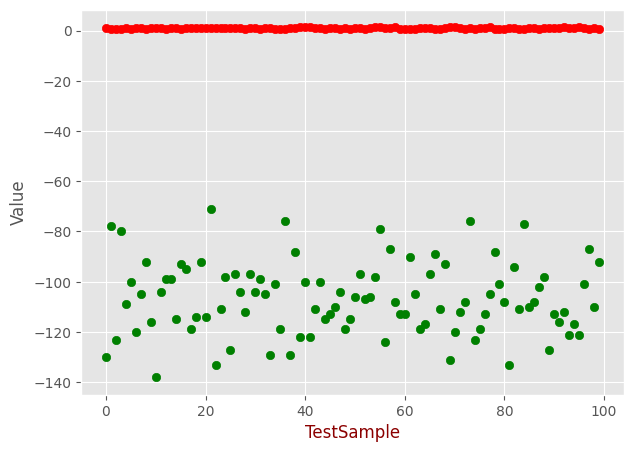

In [7]:
episode_returns,timepoints,a_best,seed_best,R_best = azt.agent(
    game="zg/ZoningGameEnv-v0", n_ep=50, n_mcts=10, max_ep_len=300, lr=0.00001,
    c=1.5, gamma=1.0, data_size=1000, batch_size=32, temp=1.0, n_hidden_layers=2, n_hidden_units=128, nsites=20)

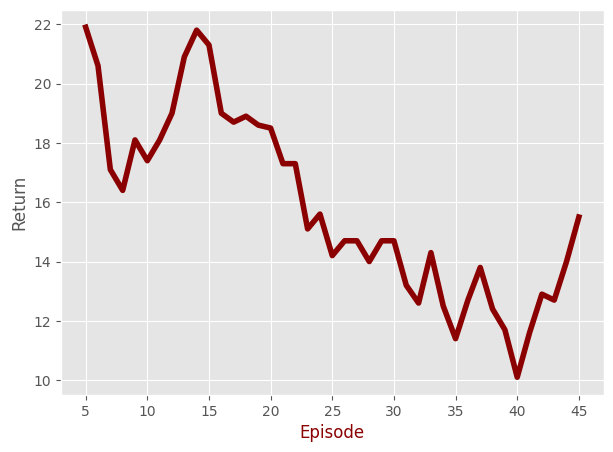

In [8]:
def plot_results(episode_returns, window=10):
    fig,ax = plt.subplots(1,figsize=[7,5])
    total_eps = len(episode_returns)
    episode_returns_smoothed = helpers.smooth(episode_returns,window,mode='valid') 
    ax.plot(helpers.symmetric_remove(np.arange(total_eps),window-1),episode_returns_smoothed,linewidth=4,color='darkred')
    ax.set_ylabel('Return')
    ax.set_xlabel('Episode',color='darkred')
    plt.plot()
plot_results(episode_returns)

## Rules

In [157]:
from nsai_experiments.zoning_game.zg_cfg import ZONING_GAME_GRAMMAR_STRING, ZONING_GAME_GRAMMAR, generate_one_probabilistic, print_ruleset
print_ruleset(generate_one_probabilistic(ZONING_GAME_GRAMMAR, seed=42))

DOWNTOWN must ( form_cluster_with_fewer_than 4 tiles or ( ( not ( not form_cluster_with_fewer_than 5 tiles ) ) or ( not ( be_within 5 tiles_of board_corner and ( not form_cluster_with_fewer_than 4 tiles ) ) ) ) ) ;
RESIDENTIAL must be_within 5 tiles_of COMMERCIAL ;
INDUSTRIAL must ( be_within 5 tiles_of board_edge and form_fewer_than 2 separate_clusters ) ;
RESIDENTIAL must ( form_fewer_than 4 separate_clusters or form_fewer_than 3 separate_clusters ) ;
INDUSTRIAL must be_within 4 tiles_of board_edge ;
COMMERCIAL must ( not form_cluster_with_fewer_than 1 tiles ) ;
INDUSTRIAL must form_fewer_than 3 separate_clusters ;

